# **Basic Image Retrieval Project (baseline)**
Download the dataset [here](https://drive.google.com/file/d/1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z/view?usp=sharing)

0. Prepare the dataset

In [1]:
from google.colab import output

!unzip image_retrieval_dataset.zip
!rm -rf sample_data
!rm image_retrieval_dataset.zip

output.clear()

1. Import libraries

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

2. Read the dataset

In [3]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)
src_images = []
for filename in image_filenames:
  filepath = os.path.join(dataset_dir, filename)
  image = cv2.imread(filepath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  src_images.append(image)

3. Data preprocessing

In [4]:
def image_resize(images, target_size=(64,64)):
  resized_image = cv2.resize(images, target_size)
  return resized_image

In [5]:
def calculate_mean_std(images):
  mean = np.mean(images, axis=(0,1,2))
  std = np.std(images, axis=(0,1,2))
  return mean, std

In [6]:
def image_std_normalize(images, mean, std):
  normalized_image = (images - mean) / std
  return normalized_image

In [7]:
def image_flatten(images, is_batch=False):
  if is_batch:
    flattened_image = images.reshape(images.shape[0], -1)
  else:
    flattened_image = images.reshape(-1)

  return flattened_image

In [8]:
def preprocess_batches(images):
  resized_images = [image_resize(image) for image in src_images]
  images_arr = np.array(resized_images)
  mean, std = calculate_mean_std(images_arr)
  normalized_images = image_std_normalize(images_arr, mean, std)
  flattened_images = image_flatten(normalized_images, is_batch=True)

  return flattened_images, mean, std

In [ ]:
preprocessed_src_images, mean, std = preprocess_batches(src_images)

In [9]:
def preprocess_query(image):
  resized_image = image_resize(image)
  normalized_image = image_std_normalize(resized_image, mean, std)
  flattened_image = image_flatten(normalized_image)

  return flattened_image

4. Evaluating metrics

In [10]:
def mean_absolute_error(query_vector, src_vectors):
  abs_diff = np.abs(src_vectors - query_vector)
  mae = np.mean(abs_diff, axis=1)

  return mae

def mean_squared_error(query_vector, src_vectors):
  squared_diff = (src_vectors - query_vector)**2
  mse = np.mean(squared_diff, axis=1)

  return mse

def cosine_similarity(query_vector, src_vectors):
  query_norm = np.linalg.norm(query_vector)
  normalized_query = query_vector / query_norm
  src_norms = np.linalg.norm(src_vectors, axis=1)
  normalized_src = src_vectors / src_norms[:, np.newaxis]

  cosine_similarity = np.dot(normalized_src, normalized_query)

  return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
  return np.corrcoef(query_vector, src_vectors)[:-1, -1]

5. Defining rank function

In [11]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
  scores = cosine_similarity(preprocessed_query_image, preprocessed_src_images)

  ranked_list = np.argsort(scores)[::-1][:top_k]
  scores = scores[ranked_list]

  return ranked_list, scores

6. Retrieving images

Query Image


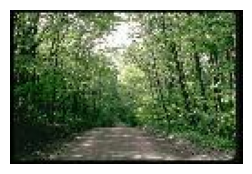

Top 10 results


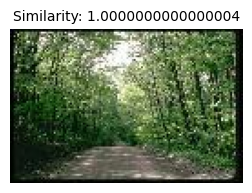

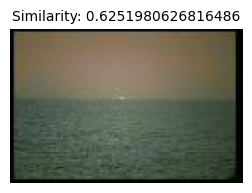

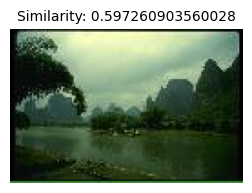

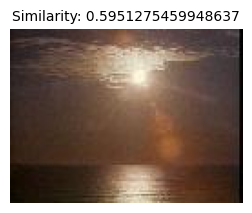

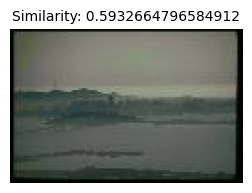

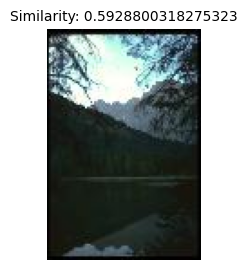

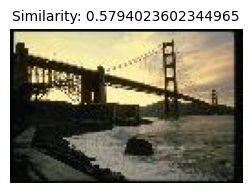

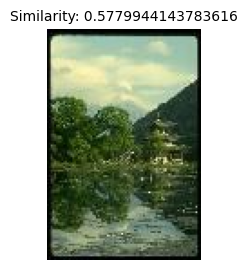

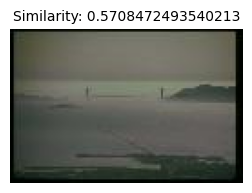

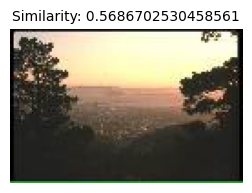

In [13]:
query_image_paths = ['images_mr/1885.jpg']
top_k = 10

for query_image_path in query_image_paths:
  query_image = cv2.imread(query_image_path, 1)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
  preprocessed_query_image = preprocess_query(query_image)

  ranked_list, scores = ranking(
      preprocessed_query_image,
      preprocessed_src_images,
      top_k
      )

  print('Query Image')
  plt.figure(figsize=(3,3))
  plt.imshow(query_image)
  plt.axis('off')
  plt.show()
  print(f'Top {top_k} results')
  for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3,3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f'Similarity: {similarity_score}', fontsize=10)
    plt.axis('off')
    plt.show()